<a href="https://www.kaggle.com/code/yorkyong/exploring-eeg-a-beginner-s-guide?scriptVersionId=159333387" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>1 |</span></b> <b>INTRODUCTION</b></div>

👋 Welcome to "🧠Exploring EEG: A Beginner's Guide"! 

If you're fascinated by the wonders of the human brain and the intricate patterns of brainwaves, but find the world of Electroencephalography (EEG) analysis daunting, you're in the right place. 

This notebook is designed for beginners like me & you, aiming to demystify the complexities of EEG data and make your learning journey both enjoyable and informative.

### <b><span style='color:#FFCE30'> 1.1 |</span> Intention of the notebook</b>
In this notebook, we will embark on an exploratory journey into the realm of EEG data analysis. Our goal is to provide a clear, step-by-step guide to understanding and analyzing EEG signals, which are crucial in detecting and classifying brain activities, such as seizures. We aim to:

* Break down complex concepts into easily digestible sections.
* Illustrate each step with practical code examples.
* Reference public notebooks and discussions to enhance your learning experience.


### <b><span style='color:#FFCE30'> 1.2 |</span> Learning Objective</b>
By the end of this notebook, you will have a foundational understanding of:

* The basics of EEG signals and their significance in medical research and neurology.
* How to preprocess and analyze EEG data.
* Run through the basic code to build a machine learning model for EEG data classification.

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>2 |</span></b> <b>REFERENCE & ACKNOWLEDGEMENT</b></div>

This notebook wouldn't be possible without the valuable insights and contributions from the Kaggle community. I've leveraged several resources to compile the most effective learning path for us:

* https://www.kaggle.com/code/cdeotte/catboost-starter-lb-0-8
* https://www.kaggle.com/code/mvvppp/hms-eda-and-domain-journey
* https://www.kaggle.com/code/ksooklall/hms-banana-montage
* https://www.kaggle.com/code/mpwolke/seizures-classification-parquet


Feel free to explore these resources alongside this notebook to deepen your understanding.

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>3 |</span></b> <b>LOAD LIBARIES</b></div>

In [1]:
import os
import pandas as pd, numpy as np
from glob import glob
import matplotlib.pyplot as plt
VER = 1

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>4 |</span></b> <b>INTRODUCTION TO EEG AND SEIZURE DETECTION</b></div>

<b><span style='color:#FFCE30'> 4.1 |</span> Electroencephalography (EEG) - The Window into Brain Activity</b>

* Electroencephalography, commonly known as EEG, is a non-invasive method used by medical professionals to record electrical activity in the brain. 
* This is done using electrodes placed along the scalp. 
* EEG is a crucial tool in diagnosing neurological disorders, especially epilepsy, which is characterized by recurrent seizures.

<img src="https://www.researchgate.net/profile/Sebastian-Nagel-4/publication/338423585/figure/fig1/AS:844668573073409@1578396089381/Sketch-of-how-to-record-an-Electroencephalogram-An-EEG-allows-measuring-the-electrical.png" alt="EEG" width="600" height="400">



In [2]:
# check the reading of one parquet for understanding

BASE_PATH = '/kaggle/input/hms-harmful-brain-activity-classification/'

df = pd.DataFrame({'path': glob(BASE_PATH + '**/*.parquet')})
df['test_type'] = df['path'].str.split('/').str.get(-2).str.split('_').str.get(-1)
df['id'] = df['path'].str.split('/').str.get(-1).str.split('.').str.get(0)

df_eeg = pd.read_parquet(BASE_PATH + 'train_eegs/1000913311.parquet')
df_eeg.head()

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-105.849998,-89.230003,-79.459999,-49.230000,-99.730003,-87.769997,-53.330002,-50.740002,-32.250000,-42.099998,-43.270000,-88.730003,-74.410004,-92.459999,-58.930000,-75.739998,-59.470001,8.210000,66.489998,1404.930054
1,-85.470001,-75.070000,-60.259998,-38.919998,-73.080002,-87.510002,-39.680000,-35.630001,-76.839996,-62.740002,-43.040001,-68.629997,-61.689999,-69.320000,-35.790001,-58.900002,-41.660000,196.190002,230.669998,3402.669922
2,8.840000,34.849998,56.430000,67.970001,48.099998,25.350000,80.250000,48.060001,6.720000,37.880001,61.000000,16.580000,55.060001,45.020000,70.529999,47.820000,72.029999,-67.180000,-171.309998,-3565.800049
3,-56.320000,-37.279999,-28.100000,-2.820000,-43.430000,-35.049999,3.910000,-12.660000,8.650000,3.830000,4.180000,-51.900002,-21.889999,-41.330002,-11.580000,-27.040001,-11.730000,-91.000000,-81.190002,-1280.930054
4,-110.139999,-104.519997,-96.879997,-70.250000,-111.660004,-114.430000,-71.830002,-61.919998,-76.150002,-79.779999,-67.480003,-99.029999,-93.610001,-104.410004,-70.070000,-89.250000,-77.260002,155.729996,264.850006,4325.370117


In [3]:
# Determine the number of channels
# Assuming each row is a time point and each column is a channel
n_channels = df_eeg.shape[1]
n_channels

20

* The headers in the dataset (Fp1, F3, C3, P3, F7, T3, T5, O1, Fz, Cz, Pz, Fp2, F4, C4, P4, F8, T4, T6, O2, EKG) are standard electrode placement labels used in electroencephalography (EEG). 
* These labels correspond to specific positions on the scalp where EEG electrodes are placed to record brain activity. 
* Here's a brief overview of what they represent:

1. **Fp1, Fp2:** Frontopolar electrodes, located on the forehead, left and right side.
2. **F3, F4:** Frontal electrodes, on the left and right side of the forehead.
3. **C3, C4:** Central electrodes, placed above the left and right hemispheres of the brain.
4. **P3, P4:** Parietal electrodes, located on the upper back portion of the head, left and right sides.
5. **O1, O2:** Occipital electrodes, positioned at the back of the head near the visual cortex.
6. **T3, T4, T5, T6:** Temporal electrodes, situated on the left and right sides of the head near the ears. They are often involved in monitoring auditory functions.
7. **F7, F8:** Frontal-temporal electrodes, located at the front of the temporal lobes.
8. **Fz, Cz, Pz:** Midline electrodes, located at the frontal (Fz), central (Cz), and parietal (Pz) positions on the midline of the head.
9. **EKG:** Electrocardiogram electrode, which records the heart’s electrical activity. It's not directly related to brain activity but can be important in some EEG analyses.


<img src="https://www.researchgate.net/profile/Danny-Plass-Oude-Bos/publication/237777779/figure/fig3/AS:669556259434497@1536646060035/10-20-system-of-electrode-placement.png" alt="10-20-system-of-electrode-placement" width="300" height="150">

<b><span style='color:#FFCE30'> 4.2 |</span> Seizures and Their Impact</b>
* Seizures are sudden, uncontrolled electrical disturbances in the brain that can cause changes in behavior, feelings, movements, and levels of consciousness. 
* Detecting and classifying seizures accurately is vital for appropriate treatment and care, especially in critically ill patients.

<b><span style='color:#FFCE30'> 4.3 |</span> The Challenge of Manual EEG Analysis</b>

* Traditionally, EEG data analysis relies on visual inspection by trained neurologists. 
* This process is not only time-consuming and labor-intensive but also prone to errors due to fatigue and subjective interpretation.

<img src="https://slideplayer.com/slide/12925171/78/images/2/Manual+Interpretation+of+EEGs.jpg" alt="Manual Interpretation of EEG" width="700" height="300">
Source: Automated Identification of Abnormal Adult EEG, S. López, G. Suarez, D. Jungreis, I. Obeid and J. Picone, Neural Engineering Data Consortium, Temple University


<b><span style='color:#FFCE30'> 4.4 |</span> The Role of Data Science in EEG Analysis</b>

* Automating EEG Interpretation
The advent of machine learning and data science offers an opportunity to automate the interpretation of EEG data. By developing algorithms that can detect and classify different patterns in EEG signals, we can aid neurologists in making faster, more accurate diagnoses.

* The Data Science Approach
Data scientists approach this challenge by first preprocessing the EEG data, which involves filtering out noise and extracting relevant features. Machine learning models are then trained on these features to distinguish between different types of brain activity.

<img src="https://www.researchgate.net/profile/Huiguang-He/publication/336336651/figure/fig1/AS:834361356197888@1575938657076/The-flow-chart-of-EEG-emotion-classification-with-similarity-learning-network.png" alt="flowchart for EEG classification" width="700" height="300">


<b><span style='color:#FFCE30'> 4.5 |</span> Understanding EEG Patterns</b>

In the realm of EEG analysis for seizure detection, certain patterns are of particular interest:

1. **Seizure (SZ):** Characterized by abnormal rhythmic activity, indicative of a seizure.
2. **Generalized Periodic Discharges (GPD):** Patterns that may be seen in various encephalopathies.
3. **Lateralized Periodic Discharges (LPD):** Often associated with focal brain lesions.
4. **Lateralized Rhythmic Delta Activity (LRDA):** Can be observed in focal brain dysfunction.
5. **Generalized Rhythmic Delta Activity (GRDA):** Typically related to diffuse brain dysfunction.
6. **"Other" Patterns:** Any other type of activity not falling into the above categories.

<b><span style='color:#FFCE30'> 4.6 |</span> Interpreting Complex EEG Data</b>

EEG data interpretation can be complex, especially in edge cases where expert neurologists may not agree on a classification. This is where machine learning models can particularly shine by providing an additional layer of analysis.

<img src="https://www.neurology.org/cms/10.1212/WNL.0000000000207127/asset/bd84c182-712c-41ab-8742-cecf9d49a322/assets/images/large/5ff2.jpg" alt="flowchart for EEG classification" width="700" height="300">

Source: Development of Expert-Level Classification of Seizures and Rhythmic and Periodic Patterns During EEG Interpretation https://www.neurology.org/doi/10.1212/WNL.0000000000207127


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>5 |</span></b> <b>LOAD TRAIN DATA</b></div>

In [4]:
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>6 |</span></b> <b>CREATE NON-OVERLAPPING EEG ID TRAIN DATA</b></div>

Following the notebook from Chris Deotte: https://www.kaggle.com/code/cdeotte/catboost-starter-lb-0-8,
Initial discussion found here https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

We perform the following because:

* **Match Training Data with Test Data Format:** The competition states that the test data does not have multiple segments from the same eeg_id. To make the training data similar to the test data, we also use only one segment per eeg_id in the training data.

* **Remove Redundancies:** This approach ensures that the training data does not have overlapping or redundant information, which can lead to a more accurate and generalizable machine learning model.

* **Consistency in Data:** By standardizing how we handle the EEG segments in training, we ensure that our model learns from data that is consistent in format with the data it will be tested on.

* **Data Preparation for Machine Learning:** The normalization of target variables and inclusion of relevant features like patient_id and expert_consensus prepare the dataset for effective machine learning modeling.

In [5]:
# Creating a Unique EEG Segment per eeg_id:
# The code groups (groupby) the EEG data (df) by eeg_id. Each eeg_id represents a different EEG recording.
# It then picks the first spectrogram_id and the earliest (min) spectrogram_label_offset_seconds for each eeg_id. This helps in identifying the starting point of each EEG segment.
# The resulting DataFrame train has columns spec_id (first spectrogram_id) and min (earliest spectrogram_label_offset_seconds).
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']


# Finding the Latest Point in Each EEG Segment:
# The code again groups the data by eeg_id and finds the latest (max) spectrogram_label_offset_seconds for each segment.
# This max value is added to the train DataFrame, representing the end point of each EEG segment.
tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp


tmp = df.groupby('eeg_id')[['patient_id']].agg('first') # The code adds the patient_id for each eeg_id to the train DataFrame. This links each EEG segment to a specific patient.
train['patient_id'] = tmp


tmp = df.groupby('eeg_id')[TARGETS].agg('sum') # The code sums up the target variable counts (like votes for seizure, LPD, etc.) for each eeg_id.
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values # It then normalizes these counts so that they sum up to 1. This step converts the counts into probabilities, which is a common practice in classification tasks.
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first') # For each eeg_id, the code includes the expert_consensus on the EEG segment's classification.
train['target'] = tmp

train = train.reset_index() # This makes eeg_id a regular column, making the DataFrame easier to work with.
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>7 |</span></b> <b>FEATURE ENGINEERING</b></div>



<b><span style='color:#FFCE30'> 7.1 |</span> 10 min and 20 sec windows</b>

* The code belows efficiently reads spectrogram data, from a single combined file, based on the set variable. We relied on the dataset by Chris Deotte to save time. https://www.kaggle.com/datasets/cdeotte/brain-spectrograms
* It then performs feature engineering by calculating mean and minimum values over two different time windows for each frequency in the spectrogram.
It produce produces in 1600 features (400 features × 4 calculations) for each EEG ID.
* The new features are intended to help the model better understand and classify the EEG data.
* This approach is designed to enhance the model's performance by providing it with more detailed information derived from the spectrogram data.

In [6]:
READ_SPEC_FILES = False # If READ_SPEC_FILES is False, the code reads the combined file instead of individual files.
FEATURE_ENGINEER = True

In [7]:
%%time
# READ ALL SPECTROGRAMS
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_SPEC_FILES:    
    spectrograms = {}
    for i,f in enumerate(files):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
else:
    spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()

There are 11138 spectrogram parquets
CPU times: user 4.55 s, sys: 9.72 s, total: 14.3 s
Wall time: 1min 8s


In [8]:
%time
# ENGINEER FEATURES
import warnings
warnings.filterwarnings('ignore')

# The code generates features from the spectrogram data for use in a model 
# The features are derived by calculating the mean and minimum values over time for each of the 400 spectrogram frequencies.
# Two types of windows are used for these calculations:
# A 10-minute window (_mean_10m, _min_10m).
# A 20-second window (_mean_20s, _min_20s).
# This process results in 1600 features (400 features × 4 calculations) for each EEG ID.

SPEC_COLS = pd.read_parquet(f'{PATH}1000086677.parquet').columns[1:]
FEATURES = [f'{c}_mean_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_min_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_mean_20s' for c in SPEC_COLS]
FEATURES += [f'{c}_min_20s' for c in SPEC_COLS]
print(f'We are creating {len(FEATURES)} features for {len(train)} rows... ',end='')


# A data matrix data is initialized to store the new features for each eeg_id in the train DataFrame.
# For each row in train, the code calculates the mean and minimum values within the specified 10-minute and 20-second windows.
# These calculated values are then stored in the data matrix.
# Finally, the matrix is added to the train DataFrame as new columns.

if FEATURE_ENGINEER:
    data = np.zeros((len(train),len(FEATURES)))
    for k in range(len(train)):
        if k%100==0: print(k,', ',end='')
        row = train.iloc[k]
        r = int( (row['min'] + row['max'])//4 ) 
        
        # 10 MINUTE WINDOW FEATURES (MEANS and MINS)
        x = np.nanmean(spectrograms[row.spec_id][r:r+300,:],axis=0)
        data[k,:400] = x
        x = np.nanmin(spectrograms[row.spec_id][r:r+300,:],axis=0)
        data[k,400:800] = x
        
        # 20 SECOND WINDOW FEATURES (MEANS and MINS)
        x = np.nanmean(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
        data[k,800:1200] = x
        x = np.nanmin(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
        data[k,1200:1600] = x

    train[FEATURES] = data
else:
    train = pd.read_parquet('/kaggle/input/brain-spectrograms/train.pqt')
print()
print('New train shape:',train.shape)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 9.06 µs
We are creating 1600 features for 17089 rows... 0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 11200 , 11300 , 11400 , 11500 , 11600 , 11700 , 11800 , 11900 , 12000 , 12100 , 12200 , 12300 , 12400 , 

<b><span style='color:#FFCE30'> 7.2 |</span>  Frequency Band Analysis</b>

#### Frequency Band Feature Extraction:

* The function extract_frequency_band_features is designed to process a segment of EEG data. EEG data is a complex signal that represents the electrical activity of the brain.
* This function divides the EEG signal into different frequency bands: Delta, Theta, Alpha, Beta, and Gamma. These bands are significant in neuroscientific studies as they are associated with different brain states and activities.

![](https://ars.els-cdn.com/content/image/3-s2.0-B9780128044902000026-f02-01-9780128044902.jpg)


1. **Delta (0.5 – 4 Hz):**
Delta waves are the slowest brainwaves and are typically associated with deep sleep and restorative processes in the body. They are most prominent during dreamless sleep and play a role in healing and regeneration.
2. **Theta (4 – 8 Hz):**
Theta waves occur during light sleep, deep meditation, and REM (Rapid Eye Movement) sleep. They are linked to creativity, intuition, daydreaming, and fantasizing. Theta states are often associated with subconscious mind activities.
3. **Alpha (8 – 12 Hz):**
Alpha waves are present during physically and mentally relaxed states but still alert. They are typical in wakeful states that involve a relaxed and effortless alertness. Alpha waves aid in mental coordination, calmness, alertness, and learning.
4. **Beta (12 – 30 Hz):**
Beta waves dominate our normal waking state of consciousness when attention is directed towards cognitive tasks and the outside world. They are associated with active, busy or anxious thinking and active concentration.
5. **Gamma (30 – 45 Hz):**
Gamma waves are involved in higher mental activity and consolidation of information. They are important for learning, memory, and information processing. Gamma waves are thought to be the fastest brainwave frequency and relate to simultaneous processing of information from different brain areas.




* For each frequency band, the function applies a bandpass filter to isolate that band's signal. It then computes statistical features (mean, standard deviation, maximum, and minimum) for each band, effectively capturing the characteristics of the EEG signal in these different frequency ranges.
* The use of np.nanmean, np.nanstd, np.nanmax, and np.nanmin ensures that the calculations are robust to NaN (Not a Number) values in the data, which might occur due to various reasons like signal loss or artifacts.

#### Feature Aggregation and PCA:

* The main script initializes a Principal Component Analysis (PCA) model with the intention of reducing the dimensionality of the extracted features. PCA is a common technique used to transform high-dimensional datasets into a lower-dimensional space while retaining most of the variance in the data.
* The script iterates over rows in the train dataset, extracting EEG segments and applying the extract_frequency_band_features function to each channel in these segments. The extracted features from all channels are aggregated.
* However, before applying PCA, any NaN values in the aggregated data (data_original) are handled using mean imputation. This step ensures that the PCA algorithm, which cannot handle NaN values, receives a clean dataset.
* After imputation, PCA is applied to transform the features into a principal component space, and these transformed features are added back into the train DataFrame.
* This process ultimately results in a feature set that's potentially more informative and concise for machine learning models, helping in tasks like classification or anomaly detection in EEG data.

In [9]:
from scipy import signal
from sklearn.decomposition import PCA

In [10]:
def extract_frequency_band_features(segment):
    # Define EEG frequency bands
    eeg_bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 12), 'Beta': (12, 30), 'Gamma': (30, 45)}
    
    band_features = []
    for band in eeg_bands:
        low, high = eeg_bands[band]
        # Filter signal for the specific band
        band_pass_filter = signal.butter(3, [low, high], btype='bandpass', fs=200, output='sos')
        filtered = signal.sosfilt(band_pass_filter, segment)
        # Extract features like mean, standard deviation, etc.
        band_features.extend([np.nanmean(filtered), np.nanstd(filtered), np.nanmax(filtered), np.nanmin(filtered)])
    
    return band_features

In [11]:
# import time
# from sklearn.impute import SimpleImputer

# # Initialize a PCA model
# pca = PCA(n_components=0.95)
# print("PCA model initialized.")

# # Initialize an array for original features
# num_rows = len(train)
# num_features = 20 * n_channels  # 20 features per channel
# data_original = np.zeros((num_rows, num_features))

# print("Starting feature extraction and PCA processing...")
# start_time = time.time()

# for k in range(num_rows):
#     if k % 1000 == 0:
#         print(f"Processing row {k} of {num_rows}...")

#     row = train.iloc[k]
#     r = int((row['min'] + row['max']) // 4)
#     eeg_segment = spectrograms[row.spec_id][r:r+300, :]

#     # Apply the feature extraction function to each EEG channel
#     all_channel_features = []
#     for i in range(n_channels):
#         channel_features = extract_frequency_band_features(eeg_segment[:, i])
#         all_channel_features.extend(channel_features)
    
#     data_original[k, :] = all_channel_features

# print("Data matrix constructed")

# # Impute NaN values in the data matrix
# imputer = SimpleImputer(strategy='mean')
# data_imputed = imputer.fit_transform(data_original)

# print(f"NaN values handled. Imputed data matrix shape: {data_imputed.shape}")

# # Apply PCA on the imputed data
# pca.fit(data_imputed)
# print("PCA fitting completed.")

# # Transform data using PCA
# data_pca = pca.transform(data_imputed)

# # Add PCA features to DataFrame
# pca_feature_columns = [f'pca_feature_{i}' for i in range(data_pca.shape[1])]
# train[pca_feature_columns] = data_pca

# # Measure total processing time
# total_time = time.time() - start_time
# print(f"Total processing time: {total_time:.2f} seconds.")

In [12]:
train.head()

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,...,RP_18.16_min_20s,RP_18.36_min_20s,RP_18.55_min_20s,RP_18.75_min_20s,RP_18.95_min_20s,RP_19.14_min_20s,RP_19.34_min_20s,RP_19.53_min_20s,RP_19.73_min_20s,RP_19.92_min_20s
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,...,0.20,0.19,0.17,0.16,0.25,0.21,0.17,0.19,0.15,0.13
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,...,0.02,0.02,0.02,0.02,0.02,0.02,0.03,0.02,0.02,0.02
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,...,0.05,0.04,0.07,0.05,0.04,0.06,0.03,0.06,0.05,0.05
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,...,0.06,0.05,0.05,0.06,0.06,0.06,0.07,0.05,0.05,0.03
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,...,0.15,0.15,0.13,0.13,0.08,0.06,0.06,0.12,0.09,0.04


In [13]:
# from sklearn.preprocessing import StandardScaler

# # Columns to be excluded from scaling
# excluded_columns = ['eeg_id', 'spec_id', 'min', 'max', 'patient_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote','target']

# # Save the columns to be excluded
# excluded_data = train[excluded_columns]

# # DataFrame with only the columns to be scaled
# features = train.drop(columns=excluded_columns)

# # Initialize the StandardScaler
# scaler = StandardScaler()

# # Fit the scaler to the features and transform them
# features_scaled = scaler.fit_transform(features)

# # Create a DataFrame from the scaled features
# features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

# # Concatenate the scaled features with the excluded columns
# train_scaled_df = pd.concat([excluded_data.reset_index(drop=True),features_scaled_df,], axis=1)
# train_scaled_df 


In [14]:
# train_scaled_df.info()

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>8 |</span></b> <b>TRAIN MODEL</b></div>

* Original work uses catboost, let's try with XGBoost in this version to see the difference in model performance.

In [15]:
import xgboost as xgb
import gc
from sklearn.model_selection import KFold, GroupKFold

print('XGBoost version', xgb.__version__)

XGBoost version 2.0.3


In [16]:
all_oof = []
all_true = []
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train , train .target, train .patient_id)):   
    
    print('#'*25)
    print(f'### Fold {i+1}')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    model = xgb.XGBClassifier(
        objective='multi:softprob', 
        num_class=len(TARS),
        learning_rate = 0.1, 
                      
#         tree_method='gpu_hist',  #skip GPU acceleration
    )
    
    # Prepare training and validation data
    X_train = train.loc[train_index, FEATURES]
    y_train = train.loc[train_index, 'target'].map(TARS)
    X_valid = train.loc[valid_index, FEATURES]
    y_valid = train.loc[valid_index, 'target'].map(TARS)
    
    model.fit(X_train, y_train, 
              eval_set=[(X_valid, y_valid)], 
              verbose=True, 
              early_stopping_rounds=10)
    model.save_model(f'XGB_v{VER}_f{i}.model')
    
    oof = model.predict_proba(X_valid)
    all_oof.append(oof)
    all_true.append(train.loc[valid_index, TARGETS].values)
    
    del X_train, y_train, X_valid, y_valid, oof
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
[0]	validation_0-mlogloss:1.71525
[1]	validation_0-mlogloss:1.65074
[2]	validation_0-mlogloss:1.59639
[3]	validation_0-mlogloss:1.54921
[4]	validation_0-mlogloss:1.51127
[5]	validation_0-mlogloss:1.47471
[6]	validation_0-mlogloss:1.44130
[7]	validation_0-mlogloss:1.41417
[8]	validation_0-mlogloss:1.38801
[9]	validation_0-mlogloss:1.36416
[10]	validation_0-mlogloss:1.34616
[11]	validation_0-mlogloss:1.32763
[12]	validation_0-mlogloss:1.30994
[13]	validation_0-mlogloss:1.29378
[14]	validation_0-mlogloss:1.28079
[15]	validation_0-mlogloss:1.26874
[16]	validation_0-mlogloss:1.25603
[17]	validation_0-mlogloss:1.24528
[18]	validation_0-mlogloss:1.23556
[19]	validation_0-mlogloss:1.22740
[20]	validation_0-mlogloss:1.22049
[21]	validation_0-mlogloss:1.21151
[22]	validation_0-mlogloss:1.20529
[23]	validation_0-mlogloss:1.19835
[24]	validation_0-mlogloss:1.19216
[25]	validation_0-mlogloss:1.18574

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>9 |</span></b> <b>HYPERPARAMETER TUNING</b></div>

### <b><span style='color:#FFCE30'> 9.1 |</span> Import Libraries and Set Up Optuna</b>
* First, you import necessary libraries: optuna for hyperparameter optimization, xgboost for the machine learning model, log_loss from scikit-learn for the evaluation metric, and GroupKFold for cross-validation.
* optuna.create_study(direction='minimize') creates a new optimization study. The direction='minimize' means you want to minimize the value returned by the objective function, which in this case is the log loss.

### <b><span style='color:#FFCE30'> 9.2 |</span> Define the Objective Function</b>
* The objective function is what Optuna will optimize. This function takes a trial object, which is used to suggest values for the hyperparameters.
* Inside this function, you set up the hyperparameter space. Optuna will test different combinations of these parameters:
1. lambda, alpha: Regularization parameters.
2. colsample_bytree, subsample: Ratios for column and row sampling.
3. learning_rate: Step size shrinkage used to prevent overfitting.
4. n_estimators: Number of gradient boosted trees.
5. max_depth: Maximum depth of a tree.
6. min_child_weight: Minimum sum of instance weight needed in a child.

### <b><span style='color:#FFCE30'> 9.3 |</span> Cross-Validation Loop</b>

* The function uses GroupKFold for splitting the data. This method is suitable when you have groups in your data (like patient IDs) that should not be split across the training and validation sets.
* For each fold in the cross-validation, the function:
1. Splits the data into training and validation sets.
2. Trains an XGBoost model using the parameters suggested by Optuna.
3. Computes the log loss on the validation set.
4. The average log loss across all folds is returned. Optuna will use this value to decide which hyperparameters are best.

### <b><span style='color:#FFCE30'> 9.4 |</span> Running the Optuna Study</b>

* study.optimize(objective, n_trials=100) tells Optuna to optimize the objective function. It will try 100 different combinations of hyperparameters (n_trials=100) to find the best ones.
* It is best to start with small trials before investing time to run on more trials to manage time invested
* Once the optimization is complete, the best hyperparameters found are printed.

In [17]:
# import optuna
# from sklearn.metrics import log_loss


# def objective(trial):
#     # Hyperparameters to be tuned by Optuna
#     param = {
#         'objective': 'multi:softprob',
#         'num_class': len(TARS),
#         'tree_method': 'gpu_hist',  # use 'gpu_hist' for GPU
#         'lambda': trial.suggest_loguniform('lambda', 1e-4, 10.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-4, 10.0),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
#         'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0]),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.008, 0.01, 0.02, 0.05, 0.1]),
#         'n_estimators': 1000,
#         'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13]),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
#     }

#     gkf = GroupKFold(n_splits=5)
#     cv_scores = []

#     for train_index, valid_index in gkf.split(train, train.target, train.patient_id):
#         X_train, X_valid = train.loc[train_index, FEATURES], train.loc[valid_index, FEATURES]
#         y_train, y_valid = train.loc[train_index, 'target'].map(TARS), train.loc[valid_index, 'target'].map(TARS)

#         model = xgb.XGBClassifier(**param)
#         model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False, early_stopping_rounds=10)
#         preds = model.predict_proba(X_valid)
#         cv_scores.append(log_loss(y_valid, preds))

#     return np.mean(cv_scores)

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=10)  # Increase n_trials for more extensive search

# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

* [I 2024-01-15 06:06:55,585] A new study created in memory with name: no-name-21c5e987-7941-4f05-8e92-2903b9a7e304
* [I 2024-01-15 06:20:36,414] Trial 0 finished with value: 1.0734795198486586 and parameters: {'lambda': 8.578460041884545, 'alpha': 1.0420327876364774, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 7, 'min_child_weight': 30}. Best is trial 0 with value: 1.0734795198486586.
* [I 2024-01-15 06:39:35,894] Trial 1 finished with value: 1.0792154540612213 and parameters: {'lambda': 0.0029055528938438085, 'alpha': 0.03244985452963714, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'min_child_weight': 77}. Best is trial 0 with value: 1.0734795198486586.
* [I 2024-01-15 06:42:19,332] Trial 2 finished with value: 1.107279543251576 and parameters: {'lambda': 1.5919274718287213, 'alpha': 0.042136459342788604, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 152}. Best is trial 0 with value: 1.0734795198486586.
* [I 2024-01-15 06:57:56,577] Trial 3 finished with value: 1.107956784549986 and parameters: {'lambda': 6.873357111288177, 'alpha': 0.05538406375764404, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 7, 'min_child_weight': 108}. Best is trial 0 with value: 1.0734795198486586.
* [I 2024-01-15 07:12:36,921] Trial 4 finished with value: 1.1453593669298952 and parameters: {'lambda': 0.0012348624625841455, 'alpha': 6.698933350539058, 'colsample_bytree': 0.8, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 258}. Best is trial 0 with value: 1.0734795198486586.
* [I 2024-01-15 07:27:45,543] Trial 5 finished with value: 1.1234561427497631 and parameters: {'lambda': 0.0779496745099949, 'alpha': 0.001997110519034328, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 11, 'min_child_weight': 145}. Best is trial 0 with value: 1.0734795198486586.
* [I 2024-01-15 07:30:45,104] Trial 6 finished with value: 1.139466297500727 and parameters: {'lambda': 0.011643281906929, 'alpha': 0.06334100511005662, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 274}. Best is trial 0 with value: 1.0734795198486586.
* [I 2024-01-15 07:33:47,478] Trial 7 finished with value: 1.074140292040741 and parameters: {'lambda': 5.487810272015954, 'alpha': 2.266845998962579, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 51}. Best is trial 0 with value: 1.0734795198486586.
* [I 2024-01-15 07:48:19,863] Trial 8 finished with value: 1.1705891200455967 and parameters: {'lambda': 0.03333036846711228, 'alpha': 0.0004482362892025373, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 13, 'min_child_weight': 294}. Best is trial 0 with value: 1.0734795198486586.
* [I 2024-01-15 07:53:41,442] Trial 9 finished with value: 1.115599617296683 and parameters: {'lambda': 0.000284724944614318, 'alpha': 0.020480207664040264, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 248}. Best is trial 0 with value: 1.0734795198486586.
Number of finished trials: 10

* **Best trial: {'lambda': 8.578460041884545, 'alpha': 1.0420327876364774, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 7, 'min_child_weight': 30}**

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>10 |</span></b> <b>FEATURE IMPORTANCE</b></div>

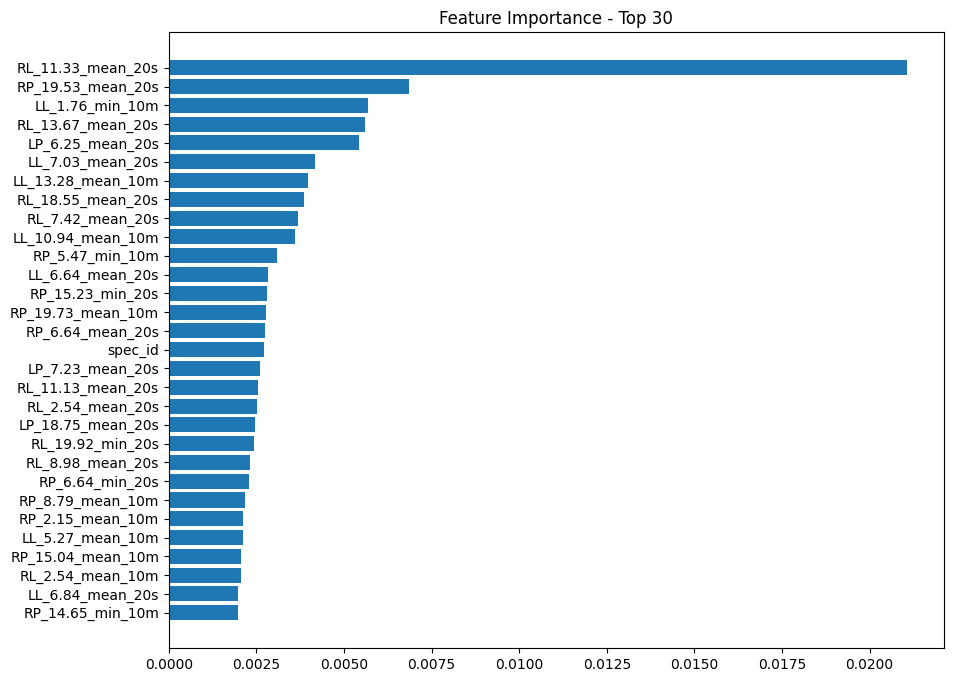

In [18]:
TOP = 30

# Assuming 'model' is your trained model
feature_importance = model.feature_importances_

# Get the feature names from 'train'
feature_names = train.columns

# Sort the feature importances and get the indices of the sorted array
sorted_idx = np.argsort(feature_importance)

# Plot only the top 'TOP' features
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center')
plt.yticks(np.arange(len(sorted_idx))[-TOP:], feature_names[sorted_idx][-TOP:])
plt.title(f'Feature Importance - Top {TOP}')
plt.show()

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>11 |</span></b> <b>INFER TEST</b></div>

In [19]:
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape',test.shape)
test.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [20]:
# PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
# spec = pd.read_parquet(f'{PATH2}{s}.parquet')
# spec

In [21]:
# %%time
# # READ ALL TEST SPECTROGRAMS
# PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
# files = os.listdir(PATH2)
# print(f'There are {len(files)} spectrogram parquets')

# spectrograms = {}
# for i,f in enumerate(files):
#     if i%100==0: print(i,', ',end='')
#     tmp = pd.read_parquet(f'{PATH2}{f}')
#     name = int(f.split('.')[0])
#     spectrograms_test[name] = tmp.iloc[:,1:].values


In [22]:
# %time
# # ENGINEER FEATURES
# import warnings
# warnings.filterwarnings('ignore')

# # The code generates features from the spectrogram data for use in a model 
# # The features are derived by calculating the mean and minimum values over time for each of the 400 spectrogram frequencies.
# # Two types of windows are used for these calculations:
# # A 10-minute window (_mean_10m, _min_10m).
# # A 20-second window (_mean_20s, _min_20s).
# # This process results in 1600 features (400 features × 4 calculations) for each EEG ID.

# SPEC_COLS = pd.read_parquet(f'{PATH}1000086677.parquet').columns[1:]
# FEATURES = [f'{c}_mean_10m' for c in SPEC_COLS]
# FEATURES += [f'{c}_min_10m' for c in SPEC_COLS]
# FEATURES += [f'{c}_mean_20s' for c in SPEC_COLS]
# FEATURES += [f'{c}_min_20s' for c in SPEC_COLS]
# print(f'We are creating {len(FEATURES)} features for {len(test)} rows... ',end='')


# # A data matrix data is initialized to store the new features for each eeg_id in the train DataFrame.
# # For each row in train, the code calculates the mean and minimum values within the specified 10-minute and 20-second windows.
# # These calculated values are then stored in the data matrix.
# # Finally, the matrix is added to the train DataFrame as new columns.

# data = np.zeros((len(test),len(FEATURES)))
# for k in range(len(test)):
#     if k%100==0: print(k,', ',end='')
#     row = test.iloc[k]
            
#     # 10 MINUTE WINDOW FEATURES
#     x = np.nanmean( spec.iloc[:,1:].values, axis=0)
#     data[k,:400] = x
#     x = np.nanmin( spec.iloc[:,1:].values, axis=0)
#     data[k,400:800] = x

#     # 20 SECOND WINDOW FEATURES
#     x = np.nanmean( spec.iloc[145:155,1:].values, axis=0)
#     data[k,800:1200] = x
#     x = np.nanmin( spec.iloc[145:155,1:].values, axis=0)
#     data[k,1200:1600] = x

#     test[FEATURES] = data

    
# print()
# print('New test shape:',test.shape)

In [23]:
# from sklearn.impute import SimpleImputer

# # Initialize a PCA model
# pca = PCA(n_components=0.95)
# print("PCA model initialized.")

# # Initialize an array for original features
# num_rows = len(test)
# num_features = 20 * n_channels  # 20 features per channel
# data_original = np.zeros((num_rows, num_features))

# print("Starting feature extraction and PCA processing...")
# start_time = time.time()

# for k in range(num_rows):
#     if k % 1000 == 0:
#         print(f"Processing row {k} of {num_rows}...")

#     row = train.iloc[k]
#     eeg_segment = spectrograms_test[853520][r:r+300, :]

#     # Apply the feature extraction function to each EEG channel
#     all_channel_features = []
#     for i in range(n_channels):
#         channel_features = extract_frequency_band_features(eeg_segment[:, i])
#         all_channel_features.extend(channel_features)
    
#     data_original[k, :] = all_channel_features

# print("Data matrix constructed")

# # Impute NaN values in the data matrix
# imputer = SimpleImputer(strategy='mean')
# data_imputed = imputer.fit_transform(data_original)

# print(f"NaN values handled. Imputed data matrix shape: {data_imputed.shape}")

# # Apply PCA on the imputed data
# pca.fit(data_imputed)
# print("PCA fitting completed.")

# # Transform data using PCA
# data_pca = pca.transform(data_imputed)

# # Add PCA features to DataFrame
# pca_feature_columns = [f'pca_feature_{i}' for i in range(data_pca.shape[1])]
# test[pca_feature_columns] = data_pca

# # Measure total processing time
# total_time = time.time() - start_time
# print(f"Total processing time: {total_time:.2f} seconds.")

# test.head()

In [24]:
# # Columns to be excluded from scaling
# excluded_columns = ['eeg_id', 'spectrogram_id', 'patient_id']

# # Save the columns to be excluded
# excluded_data = test[excluded_columns]

# # DataFrame with only the columns to be scaled
# features = test.drop(columns=excluded_columns)

# # Initialize the StandardScaler
# scaler = StandardScaler()

# # Fit the scaler to the features and transform them
# features_scaled = scaler.fit_transform(features)

# # Create a DataFrame from the scaled features
# features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

# # Concatenate the scaled features with the excluded columns
# test_scaled_df = pd.concat([excluded_data.reset_index(drop=True),features_scaled_df,], axis=1)
# test_scaled_df 


In [25]:
# FEATURE ENGINEER TEST
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
data = np.zeros((len(test),len(FEATURES)))
    
for k in range(len(test)):
    row = test.iloc[k]
    s = int( row.spectrogram_id )
    spec = pd.read_parquet(f'{PATH2}{s}.parquet')
    
    # 10 MINUTE WINDOW FEATURES
    x = np.nanmean( spec.iloc[:,1:].values, axis=0)
    data[k,:400] = x
    x = np.nanmin( spec.iloc[:,1:].values, axis=0)
    data[k,400:800] = x

    # 20 SECOND WINDOW FEATURES
    x = np.nanmean( spec.iloc[145:155,1:].values, axis=0)
    data[k,800:1200] = x
    x = np.nanmin( spec.iloc[145:155,1:].values, axis=0)
    data[k,1200:1600] = x

test[FEATURES] = data
print('New test shape',test.shape)

New test shape (1, 1603)


In [26]:
# INFER XGBOOST ON TEST
preds = []

for i in range(5):
    print(i, ', ', end='')
    
    # Load the XGBoost model
    model = xgb.XGBClassifier()
    model.load_model(f'XGB_v{VER}_f{i}.model')
    
    # Make predictions
    pred = model.predict_proba(test[FEATURES])
    preds.append(pred)

# Average the predictions from each fold
pred = np.mean(preds, axis=0)
print()
print('Test preds shape', pred.shape)

0 , 1 , 2 , 3 , 4 , 
Test preds shape (1, 6)


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>12 |</span></b> <b>SUBMISSION</b></div>

In [27]:
sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submission shape',sub.shape)
sub.head()

Submission shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.100642,0.068947,0.005433,0.104553,0.034289,0.686136


In [28]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
sub.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float32